#Word embeddings



## Setup 🔧

In [2]:
#!pip install wikipedia-api

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')
import wikipediaapi
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib
import matplotlib.pyplot as plt
import spacy
from spacy.lang.en import English
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.corpus import stopwords
import gensim.downloader as api

nltk.download('punkt')
nltk.download('stopwords')

# Default Style Settings
matplotlib.rcParams['figure.dpi'] = 300
pd.options.display.max_colwidth = 200
#%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Get members for a category together with a short description
def members_collector(category):
      mdict = {}
      categorymembers = category.categorymembers
      for c in categorymembers.values():
        if c.ns == 0:                                                            # Exclude categories within the category
          mdict[c.title] = c.summary
      return mdict

In [ ]:
# Let's collect Euphemisms
wiki = wikipediaapi.Wikipedia('en')
swiss_brands = wiki.page("Category:Swiss brands")
swiss_brands_dict = members_collector(swiss_brands)

#create a dataframe
df = pd.DataFrame([swiss_brands_dict.keys(), swiss_brands_dict.values()]).T
df.columns = ['Brand Name', 'Description']
df = df.iloc[1: , :]

In [ ]:
df.head()

,Brand Name,Description
1,ABB,"ABB Ltd (German: ABB AG, French, Italian, Romansh: ABB SA), formerly ASEA Brown Boveri, is a Swedish-Swiss multinational corporation headquartered in Västerås, Sweden, and Zürich, Switzerland. ope..."
2,Actelion,"Actelion is a pharmaceuticals and biotechnology company established in December 1997, headquartered in Allschwil near Basel, Switzerland.Actelion focuses on the manufacture of drugs that treat rar..."
3,AEBI,"AEBI is a Switzerland-based manufacturer of municipal and agriculture machinery. The company's products include transporters, Implement carriers, road sweepers, tractors, and mowers."
4,Alpa,Alpa was formerly a Swiss camera design company and manufacturer of 35 mm SLR cameras. The current owners bought the company name after bankruptcy of the original company and the company exists t...
5,Alprose,Alprose is a Swiss chocolate producer based in Caslano (Ticino). It was founded in 1957 under the name Titlis SA (in reference to the mountain in the Swiss Alps) and received its current name in 1...


## Tokenization🔨

In [ ]:
# Disable all the annotators except the tokenizer so its fast
nlp = English(disable=['tagger', 'parser', 'ner'])

def tokenize(text):
  return [t.text.lower() for t in nlp(text)]  

In [ ]:
# Apply tokenization
df['tokens'] = df['Description'].apply(word_tokenize)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['tokens_without_stopwords'] = df['tokens'].apply(lambda x: [w for w in x if not w.lower() in stop_words if w.isalnum()])
df.head()

,Brand Name,Description,tokens,tokens_without_stopwords
1,ABB,"ABB Ltd (German: ABB AG, French, Italian, Romansh: ABB SA), formerly ASEA Brown Boveri, is a Swedish-Swiss multinational corporation headquartered in Västerås, Sweden, and Zürich, Switzerland. ope...","[ABB, Ltd, (, German, :, ABB, AG, ,, French, ,, Italian, ,, Romansh, :, ABB, SA, ), ,, formerly, ASEA, Brown, Boveri, ,, is, a, Swedish-Swiss, multinational, corporation, headquartered, in, Väster...","[ABB, Ltd, German, ABB, AG, French, Italian, Romansh, ABB, SA, formerly, ASEA, Brown, Boveri, multinational, corporation, headquartered, Västerås, Sweden, Zürich, Switzerland, operating, mainly, r..."
2,Actelion,"Actelion is a pharmaceuticals and biotechnology company established in December 1997, headquartered in Allschwil near Basel, Switzerland.Actelion focuses on the manufacture of drugs that treat rar...","[Actelion, is, a, pharmaceuticals, and, biotechnology, company, established, in, December, 1997, ,, headquartered, in, Allschwil, near, Basel, ,, Switzerland.Actelion, focuses, on, the, manufactur...","[Actelion, pharmaceuticals, biotechnology, company, established, December, 1997, headquartered, Allschwil, near, Basel, focuses, manufacture, drugs, treat, rare, diseases, orphan, diseases, drugs,..."
3,AEBI,"AEBI is a Switzerland-based manufacturer of municipal and agriculture machinery. The company's products include transporters, Implement carriers, road sweepers, tractors, and mowers.","[AEBI, is, a, Switzerland-based, manufacturer, of, municipal, and, agriculture, machinery, ., The, company, 's, products, include, transporters, ,, Implement, carriers, ,, road, sweepers, ,, tract...","[AEBI, manufacturer, municipal, agriculture, machinery, company, products, include, transporters, Implement, carriers, road, sweepers, tractors, mowers]"
4,Alpa,Alpa was formerly a Swiss camera design company and manufacturer of 35 mm SLR cameras. The current owners bought the company name after bankruptcy of the original company and the company exists t...,"[Alpa, was, formerly, a, Swiss, camera, design, company, and, manufacturer, of, 35, mm, SLR, cameras, ., The, current, owners, bought, the, company, name, after, bankruptcy, of, the, original, com...","[Alpa, formerly, Swiss, camera, design, company, manufacturer, 35, mm, SLR, cameras, current, owners, bought, company, name, bankruptcy, original, company, company, exists, today, designer, manufa..."
5,Alprose,Alprose is a Swiss chocolate producer based in Caslano (Ticino). It was founded in 1957 under the name Titlis SA (in reference to the mountain in the Swiss Alps) and received its current name in 1...,"[Alprose, is, a, Swiss, chocolate, producer, based, in, Caslano, (, Ticino, ), ., It, was, founded, in, 1957, under, the, name, Titlis, SA, (, in, reference, to, the, mountain, in, the, Swiss, Alp...","[Alprose, Swiss, chocolate, producer, based, Caslano, Ticino, founded, 1957, name, Titlis, SA, reference, mountain, Swiss, Alps, received, current, name, produces, variety, chocolate, bars, napoli..."


## Fit Word2Vec Model 🦾

In [ ]:
# Train own embedding space using the word2vec architecture

# Set values for various parameters
feature_size = 100  # Word vector dimensionality
window_context = 5  # Context window size
min_word_count = 5  # Minimum word count

w2vmodel = Word2Vec(sentences=df['tokens_without_stopwords'], size=feature_size, window=window_context, min_count=min_word_count, sg = 1)

##Usage of the embeddings 💡

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# get the most common word
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

get_top_n_words(df["Description"], n=1)

[('company', 270)]

In [ ]:
# Inspect most similar words to "company"
w2vmodel.wv.most_similar('company', topn=5)

[('year', 0.9995688199996948),
 ('two', 0.9995499849319458),
 ('Harman', 0.9995487928390503),
 ('markets', 0.9995452165603638),
 ('name', 0.9995441436767578)]

The result shows that "year", "two", "Harman", "markets" and "name" are the top 5 most similar words to "company". They are have a cosine similarity that is very close to 1. However, the resutls don't seem to be that good. I would like to try changing the parameters to see if the results get better.

In [ ]:
#change to window = 10
w2vmodel_1 = Word2Vec(sentences=df['tokens_without_stopwords'], size=feature_size, window=10, min_count=min_word_count, sg = 1)

In [ ]:
w2vmodel_1.wv.most_similar('company', topn=5)

[('Harman', 0.999449610710144),
 ('customer', 0.999430775642395),
 ('Gallen', 0.9994292855262756),
 ('hearing', 0.9993991255760193),
 ('markets', 0.9993956089019775)]

With an increased value of the window parameter, the model would focus more on the semantics rather than the syntax of the words. The results are different from than the previous ones but it's hard to say which model is better.
<br> Next, let me try to change the model from using Skip-gram to CBOW.

In [ ]:
#change to sg=0 to try CBOW
w2vmodel_2 = Word2Vec(sentences=df['tokens_without_stopwords'], size=feature_size, window=10, min_count=min_word_count, sg = 0)

In [ ]:
w2vmodel_2.wv.most_similar('company', topn=5)

[('Swiss', 0.9993709921836853),
 ('UBS', 0.999259352684021),
 ('also', 0.9992284774780273),
 ('market', 0.9991822242736816),
 ('AG', 0.9991330504417419)]

After changing the word representations from Skip-gram to CBOW, the results seem to make more sense in my opinion.
<br> Now, let's try changing the value of min_count.

In [ ]:
#change to min_count=2
w2vmodel_3 = Word2Vec(sentences=df['tokens_without_stopwords'], size=feature_size, window=10, min_count=2, sg = 1)

In [ ]:
w2vmodel_3.wv.most_similar('company', topn=5)

[('multinational', 0.9995863437652588),
 ('remained', 0.999563455581665),
 ('Harman', 0.9995567798614502),
 ('GmbH', 0.9995520114898682),
 ('Geneva', 0.9995441436767578)]

By changing to min_count=2, more words are considered when training the model.<br>With our rather small dataset here, this can be helpful. 

In [ ]:
#combined model
w2vmodel = Word2Vec(sentences=df['tokens_without_stopwords'], size=feature_size, window=10, min_count=2, sg = 0)

## Visualize embeddings 🎨

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


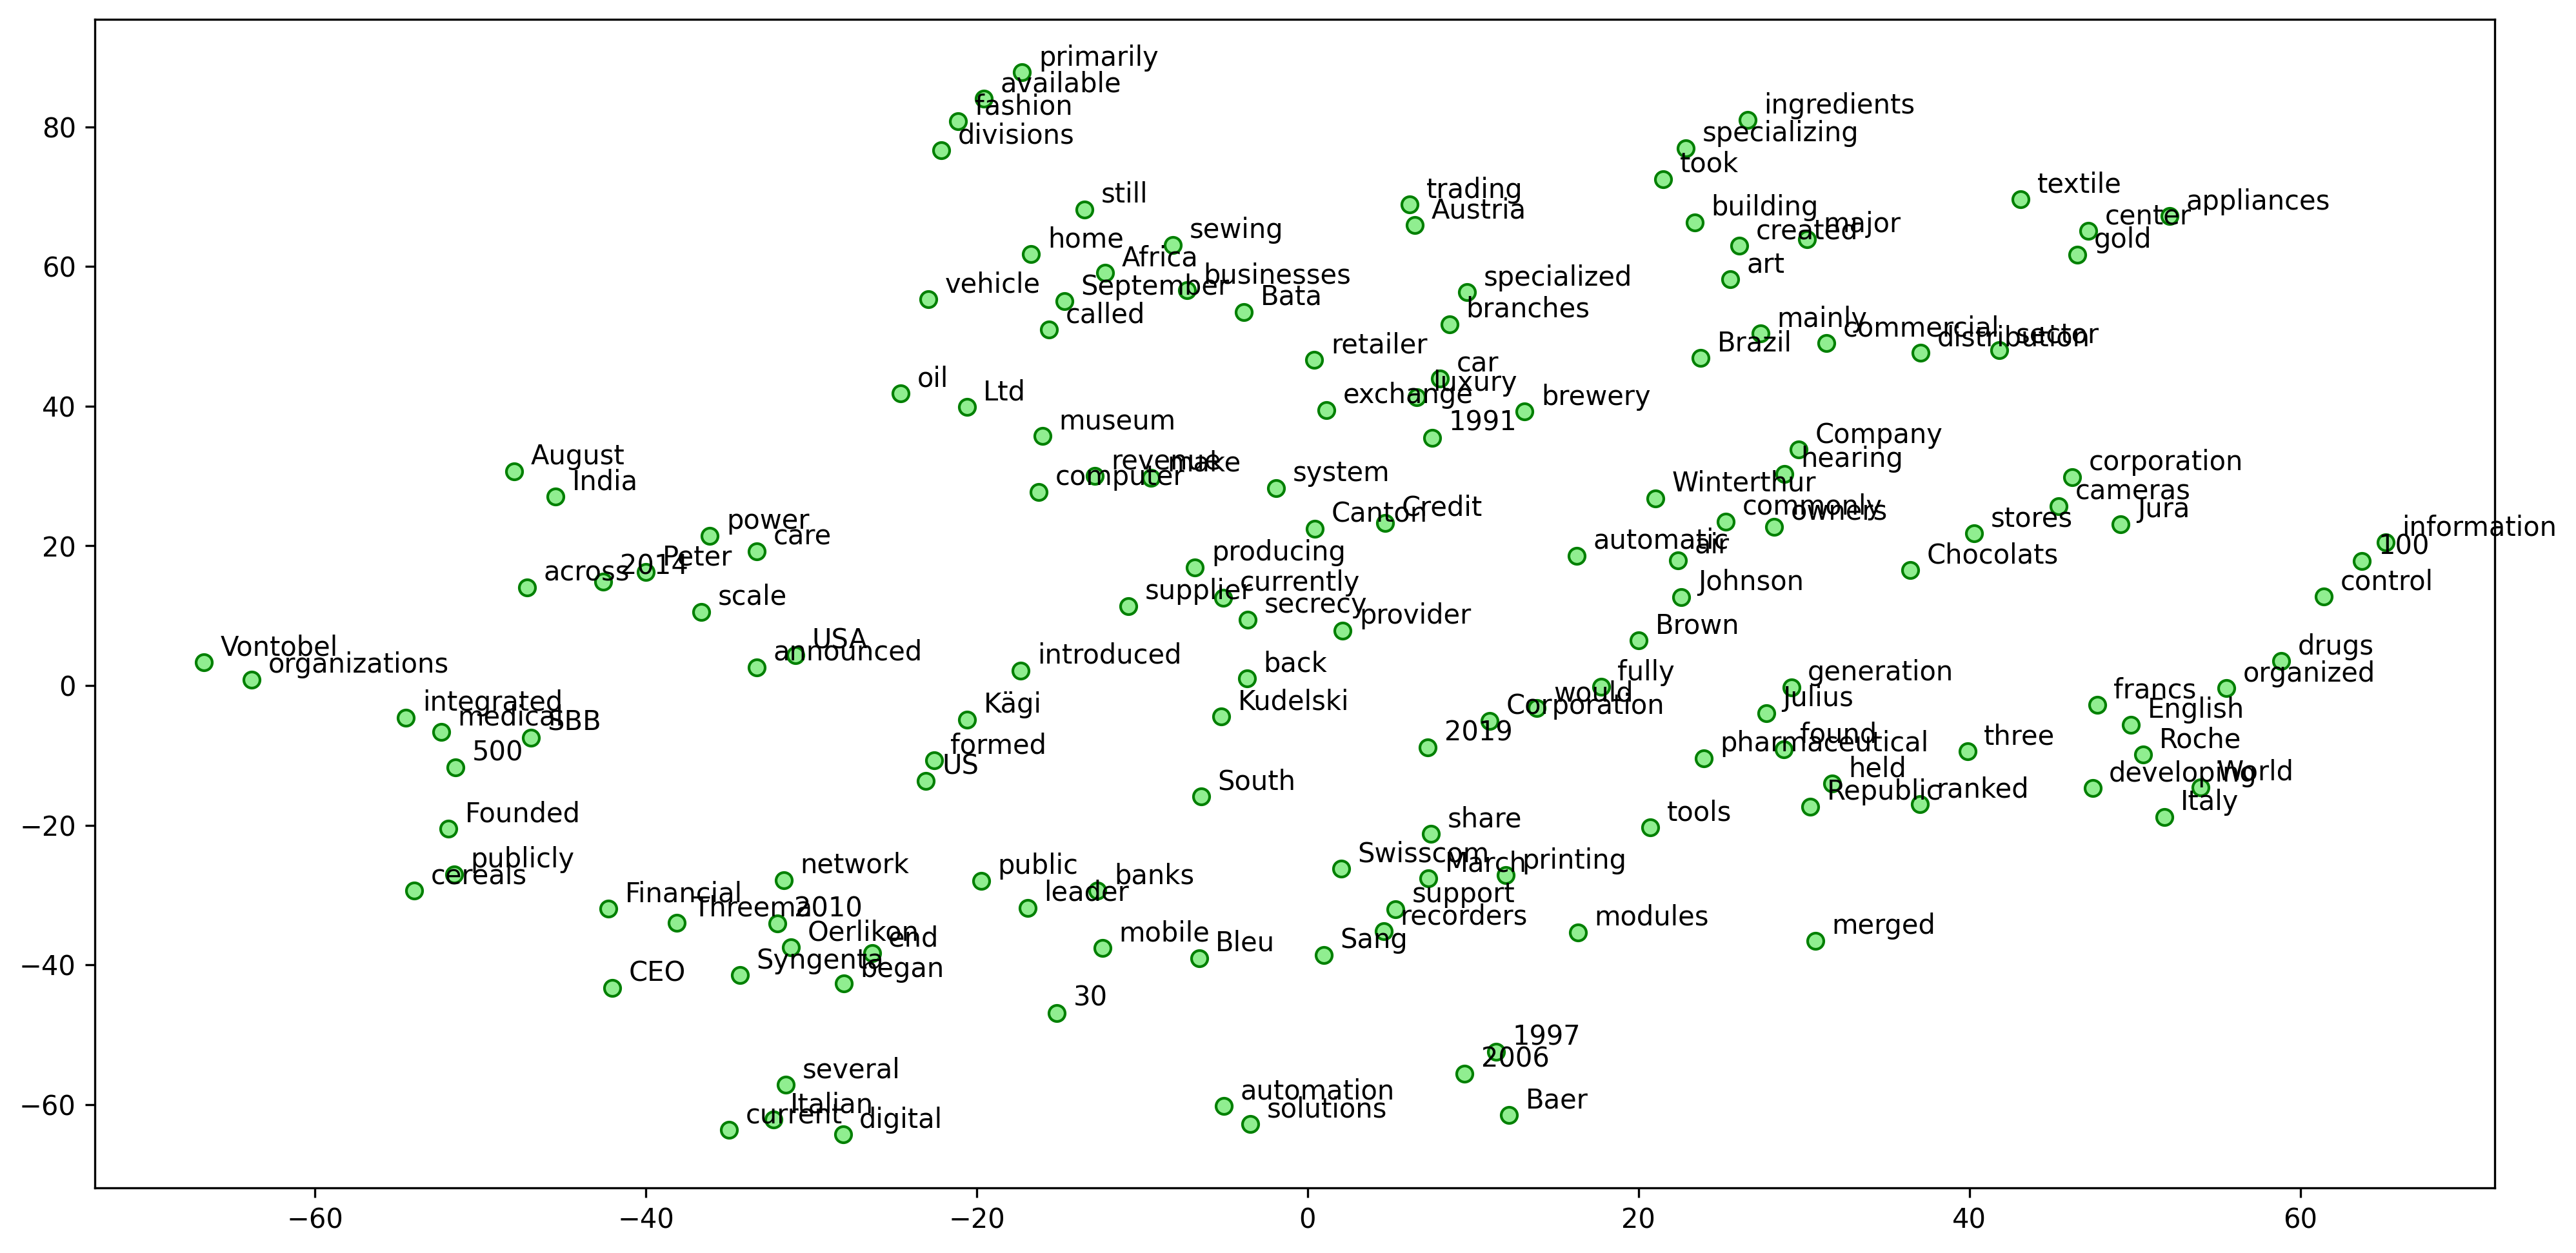

In [ ]:
from sklearn.manifold import TSNE

words = w2vmodel.wv.index2word[200:350]      ## get the word forms of voculary sample
wvs = w2vmodel.wv[words]                     ## get embeddings of word forms

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=5)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(16, 8))
plt.scatter(T[:, 0], T[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label,
                 xy=(x + 1, y + 1),
                 xytext=(0, 0),
                 textcoords='offset points')

In [ ]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word, topn=50)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.figure(figsize=(15, 8))
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


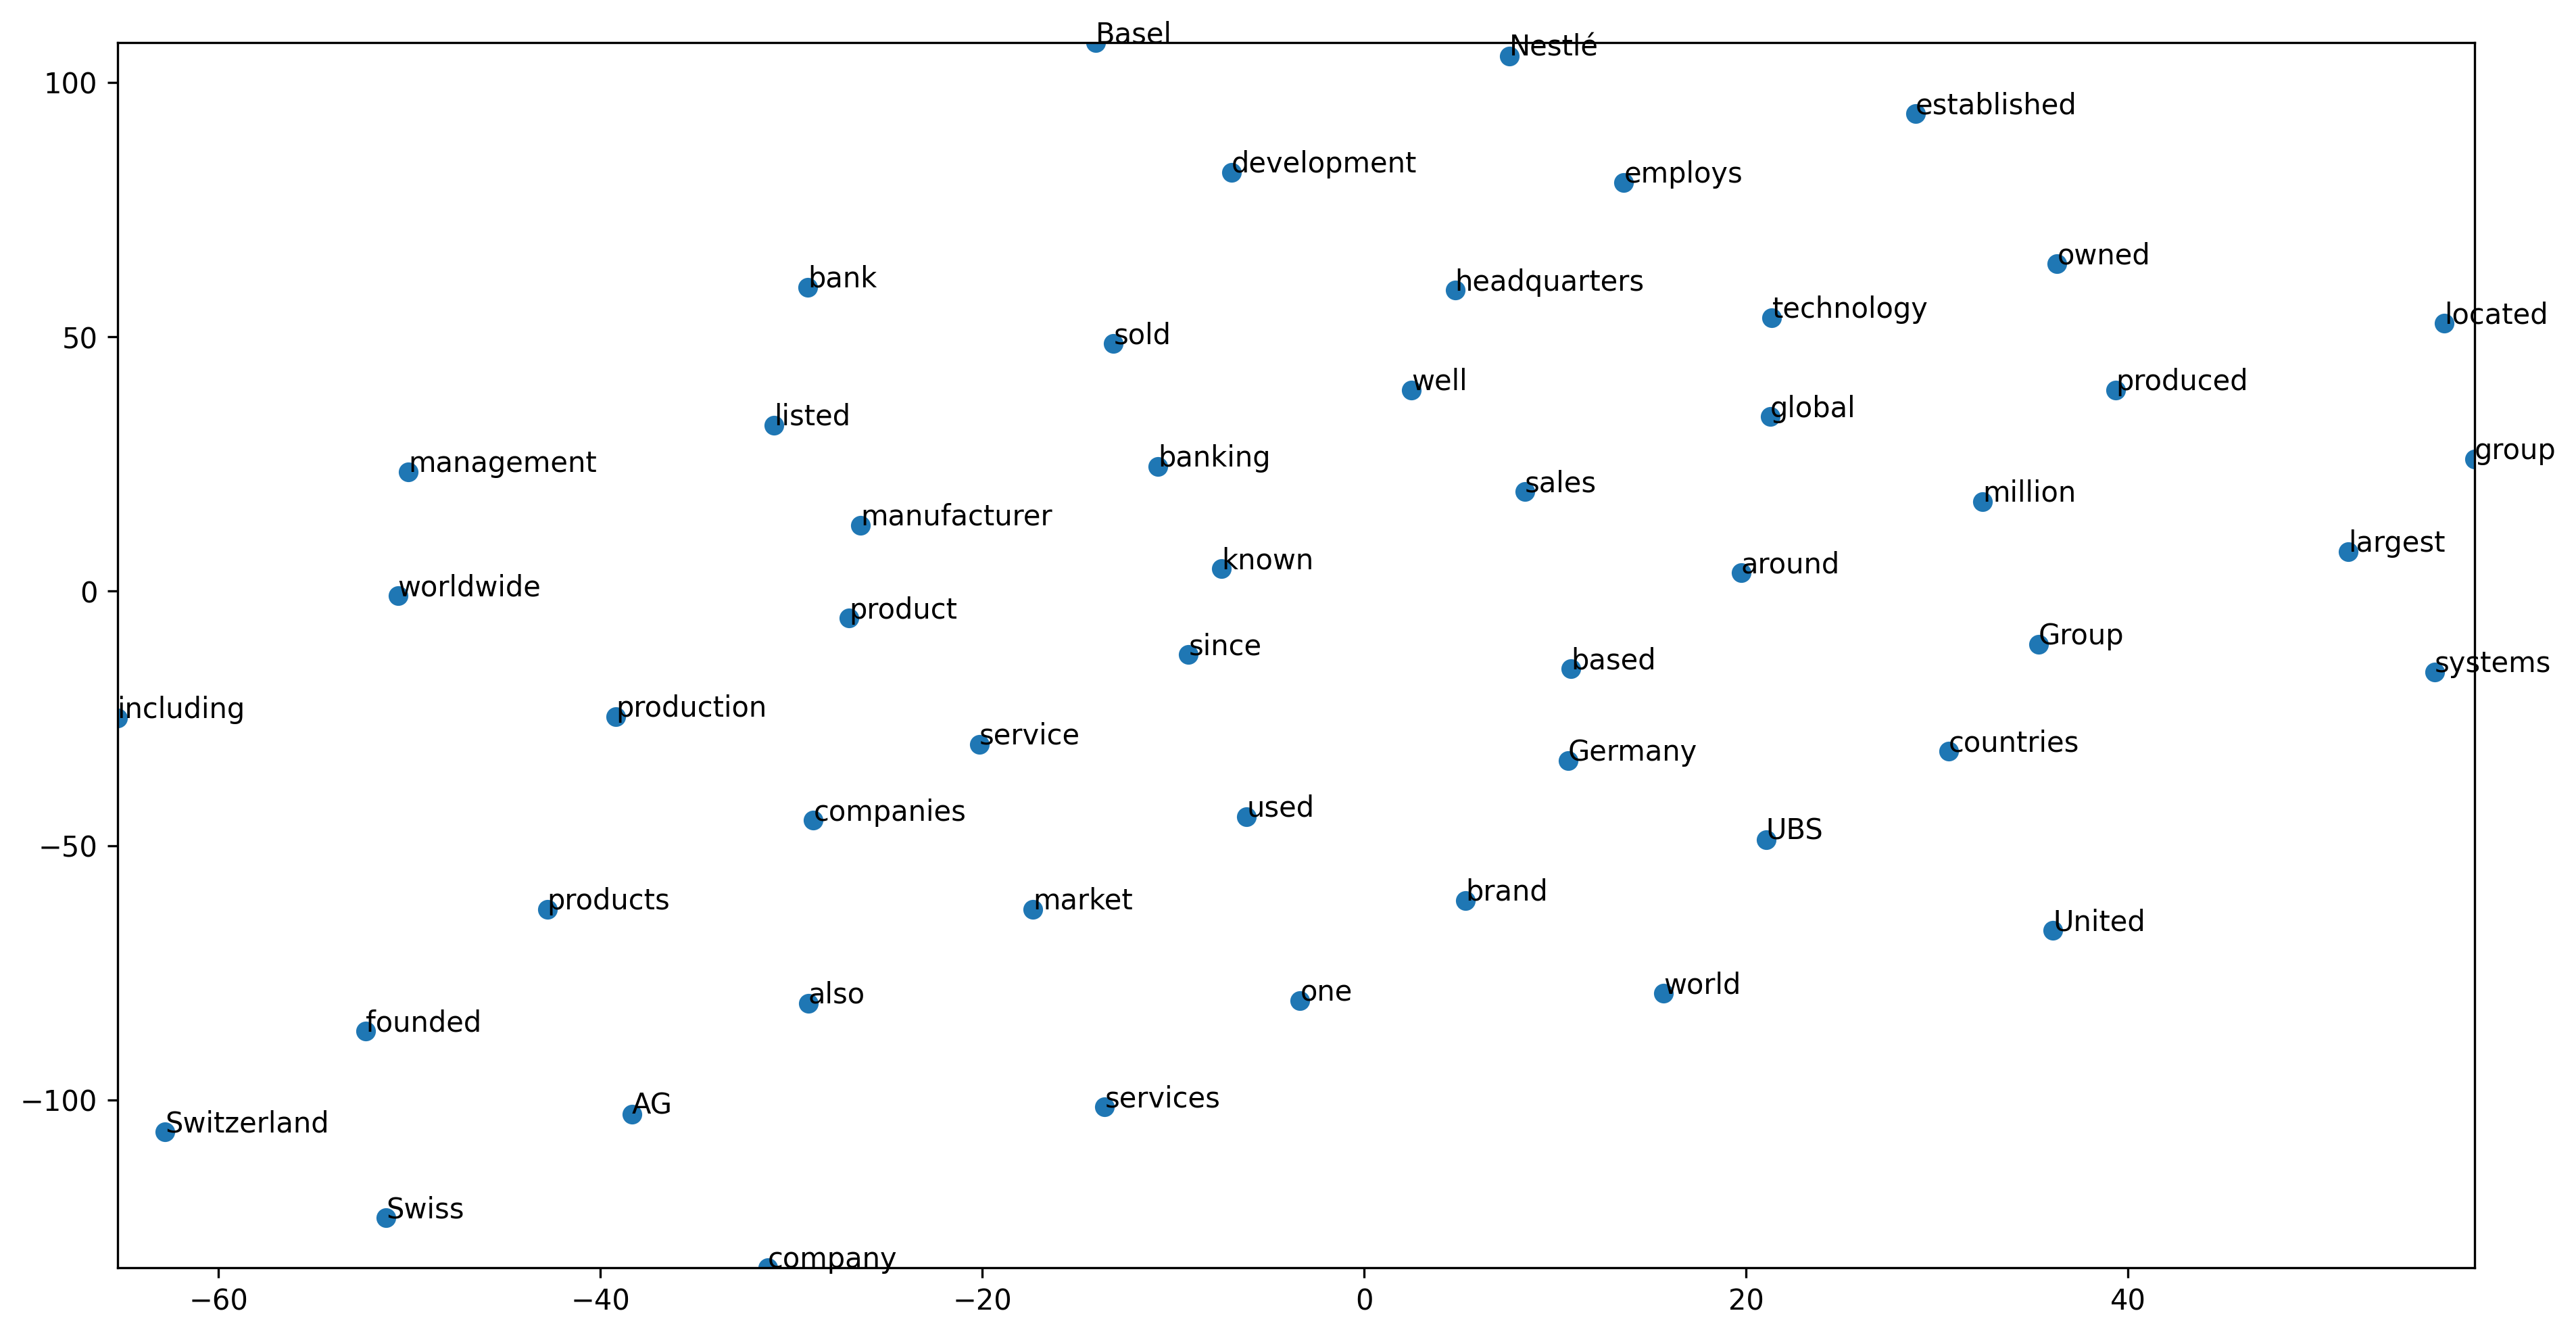

In [ ]:
# Inspect the most similar top 50 words to Basel 
display_closestwords_tsnescatterplot(w2vmodel, 'Basel', 100) 

## Pretrained word embeddings 📓

In [ ]:
#load pretrained glove embeddings
glove_vectors = api.load("glove-wiki-gigaword-100")                           

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
#Find the most similar words to company
glove_vectors.most_similar('company', topn=5)

[('companies', 0.8256460428237915),
 ('firm', 0.8072162866592407),
 ('subsidiary', 0.801094651222229),
 ('co.', 0.7880029082298279),
 ('business', 0.773224949836731)]

In [ ]:
#load pretrained fastText embeddings
ft_vectors = api.load('fasttext-wiki-news-subwords-300')                  ## fastText vectors -> will help you with OOV

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
ft_vectors.most_similar('company', topn=5)

[('sub-company', 0.7995022535324097),
 ('company--and', 0.7809797525405884),
 ('non-company', 0.7602823972702026),
 ('corporation', 0.7551683187484741),
 ('companies', 0.745854377746582)]

## Comparison 💭

In [ ]:
comparison = pd.DataFrame(
    {'Own': w2vmodel_3.wv.most_similar('company', topn=5),
     'Glove': glove_vectors.most_similar('company', topn=5),
     'fastText': ft_vectors.most_similar('company', topn=5),
    })

print("Top 5 most similar words to company")
comparison

Top 5 most similar words to company


,Own,Glove,fastText
0,"(multinational, 0.9995863437652588)","(companies, 0.8256460428237915)","(sub-company, 0.7995022535324097)"
1,"(remained, 0.999563455581665)","(firm, 0.8072162866592407)","(company--and, 0.7809797525405884)"
2,"(Harman, 0.9995567798614502)","(subsidiary, 0.801094651222229)","(non-company, 0.7602823972702026)"
3,"(GmbH, 0.9995520114898682)","(co., 0.7880029082298279)","(corporation, 0.7551683187484741)"
4,"(Geneva, 0.9995441436767578)","(business, 0.773224949836731)","(companies, 0.745854377746582)"


In this exercise, the pretrained word embeddings show more reasonable results in looking for similar words than the model trained with my own dataset. The advanatge of using pretrained word embeddings is that they are trained on large datasets and hence can apprehend the syntax and semantics of words better. It also saves us time from training the word embeddings from scratch. <br> However, languages evolves continuously over time. There are constantly new words and phrases coming up and it is hard for these pretrained word embeddings to always stay on top of the game. Also, when it comes to domain specific like legal or biomedical corpora, a lot of the words can have very different meaning from how we use them in daily life. In such a case, it is good to train the word embeddings based on the specific corpora.